In [30]:
import sys
import os
from pathlib import Path

cwd = Path.cwd().resolve().parent
sys.path.append(str(cwd))

from preprocess import VN30, preprocess_loader


In [31]:
train_loader, valid_loader, test_loader, scaler = preprocess_loader('ACB',lag = 30, batch_size=16)

In [32]:
import torch.nn as nn

class StockPredictorModel(nn.Module):
    def __init__(self, input_features, hidden_size, num_output_features):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_features, hidden_size=hidden_size, num_layers=1, batch_first=True)
        self.linear = nn.Linear(hidden_size, num_output_features)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_time_step_out = lstm_out[:, -1, :]
        y_pred = self.linear(last_time_step_out)
        return y_pred

In [33]:
import torch.optim as optim
import torch.utils.data as data
num_features = 5
hidden_layer_size = 128
model = StockPredictorModel(input_features=num_features, hidden_size=hidden_layer_size, num_output_features=num_features)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [34]:
import torch
from sklearn.metrics import r2_score
n_epochs = 50
print_every = 10 

best_val_loss = float('inf')

print("\nBắt đầu quá trình huấn luyện...")
for epoch in range(1, n_epochs+1):
    # --- training ---
    model.train()
    train_loss_sum = 0.0
    for Xb, yb in train_loader:
        pred = model(Xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item()
    avg_train_loss = train_loss_sum / len(train_loader)

    # --- tính validation loss ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xv, yv in valid_loader:
            pred = model(xv)
            loss = loss_fn(pred, yv)
            val_loss += loss.item()

    # --- lưu model nếu validation loss giảm ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_LSTM_model.pth')

    # --- in thông tin ---
    if epoch % print_every == 0 or epoch == n_epochs:
        print(f"Epoch {epoch:3d}/{n_epochs}: "
              f"Train Loss = {avg_train_loss:.6f}, "
              f"Valid Loss = {val_loss:.6f}, "
              f"Best Val Loss = {best_val_loss:.6f}")

print("\nHoàn thành huấn luyện.")


Bắt đầu quá trình huấn luyện...
Epoch  10/50: Train Loss = 0.097226, Valid Loss = 1.318478, Best Val Loss = 1.314640
Epoch  20/50: Train Loss = 0.093858, Valid Loss = 1.330146, Best Val Loss = 1.310402
Epoch  30/50: Train Loss = 0.093128, Valid Loss = 1.322339, Best Val Loss = 1.300552
Epoch  40/50: Train Loss = 0.087942, Valid Loss = 1.434571, Best Val Loss = 1.300552
Epoch  50/50: Train Loss = 0.081564, Valid Loss = 1.958372, Best Val Loss = 1.300552

Hoàn thành huấn luyện.


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np
model.load_state_dict(torch.load('best_LSTM_model.pth', map_location='cpu'))
model.eval()

with torch.no_grad():
    for xv, yv in valid_loader:
        y_pred_val = model(xv)
        y_pred_val = scaler.inverse_transform(y_pred_val)
        y_true_val = scaler.inverse_transform(yv)

mse_val = mean_squared_error(y_true_val.flatten(), y_pred_val.flatten())
rmse_val = np.sqrt(mse_val)
r2_val = r2_score(y_true_val.flatten(), y_pred_val.flatten())
mape_val = mean_absolute_percentage_error(y_true_val.flatten(), y_pred_val.flatten()) * 100

print("\n--- KẾT QUẢ TRÊN TẬP VALID  ---")
print(f"RMSE: {rmse_val}")
print(f"R²: {r2_val}")
print(f"MAPE: {mape_val}%")


--- KẾT QUẢ TRÊN TẬP VALID  ---
RMSE: 1266096.7494457087
R²: 0.8503650643251421
MAPE: 7.769248479436448%


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

model.load_state_dict(torch.load('best_LSTM_model.pth', map_location='cpu'))
model.eval()

preds = []
trues = []
with torch.no_grad():
    for xt, yt in test_loader:
        y_pred = model(xt)
        y_pred = scaler.inverse_transform(y_pred)
        y_true = scaler.inverse_transform(yt)
        preds.append(y_pred)
        trues.append(y_true)

	   

mse_test = mean_squared_error(y_true.flatten(), y_pred.flatten())
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_true.flatten(), y_pred.flatten())
mape_test = mean_absolute_percentage_error(y_true.flatten(), y_pred.flatten()) * 100

print("--- KẾT QUẢ TRÊN TẬP TEST ---")
print(f"RMSE: {rmse_test}")
print(f"R²: {r2_test}")
print(f"MAPE: {mape_test}%")

--- KẾT QUẢ TRÊN TẬP TEST ---
RMSE: 2367768.1231244626
R²: 0.6142475658802484
MAPE: 20.657229978587345%


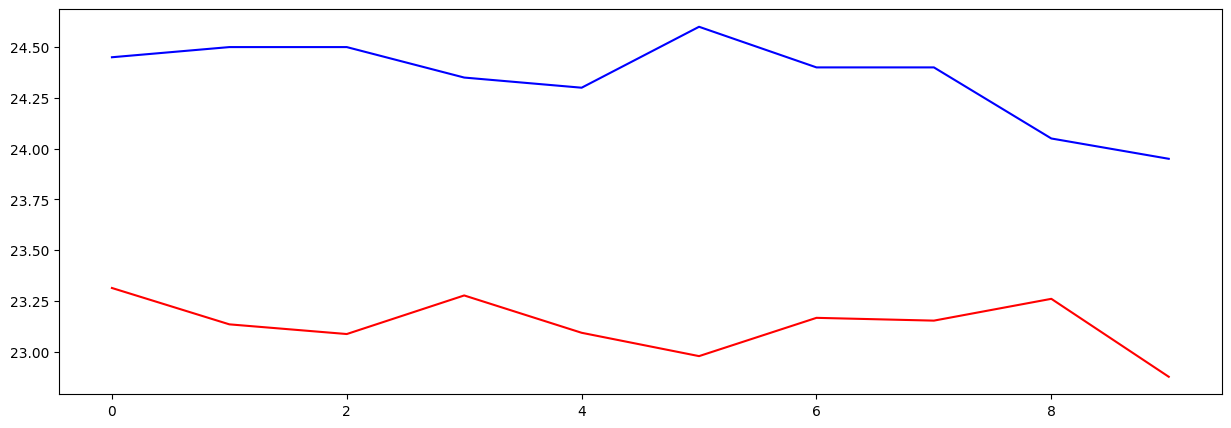

In [37]:
import matplotlib.pyplot as plt


plt.figure(figsize=(15, 5))
plt.plot(y_true[:, 0], label='Giá thực tế', color='blue')
plt.plot(y_pred[:, 0], label='Giá dự đoán', color='red')

plt.show()